# Exploring the Ames Housing Dataset

## Loading the Ames Housing Dataset into a DataFrame

In [3]:
import pandas as pd

In [4]:
columns = [
    'Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice'
]

df = pd.read_csv(
    'http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
    sep='\t',
    usecols=columns
)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [5]:
df.shape

(2930, 6)

In [6]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


In [7]:
df.isna().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [8]:
df = df.dropna(axis=0)

In [9]:
df.isna().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

## Visualizing the important characteristics of a dataset

In [10]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

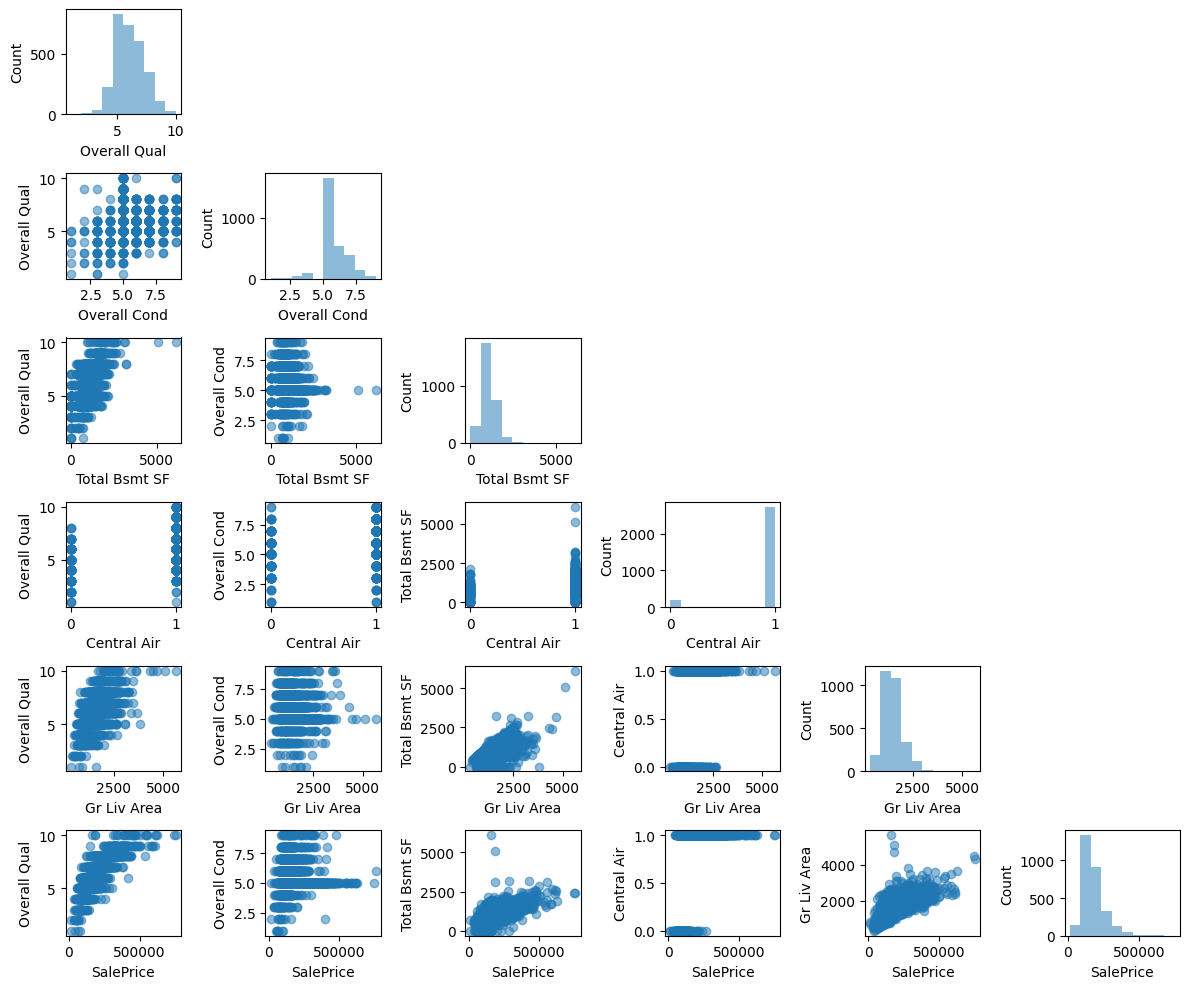

In [11]:
scatterplotmatrix(
    df.values,
    figsize=(12,10),
    names=df.columns,
    alpha=.5
)

plt.tight_layout()
plt.show()

## Looking at relationships using a correlation matrix

In [12]:
import numpy as np
from mlxtend.plotting import heatmap

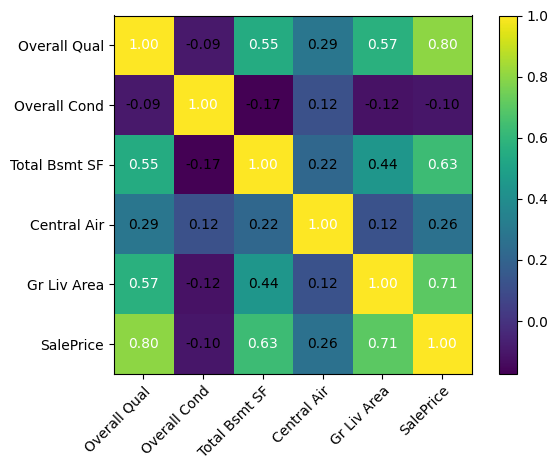

In [13]:
cm = np.corrcoef(df.values.T)
hm= heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

## Implementing an ordinary least squares linear regression model

In [14]:
from models import LinearRegressionGD
from sklearn.preprocessing import StandardScaler
from scripts import lin_regplot

In [15]:
X = df[['Gr Liv Area']].values
y = df[['SalePrice']].values

In [16]:
sc_x = StandardScaler()
sc_y = StandardScaler()

In [17]:
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()

In [18]:
lr_model = LinearRegressionGD(eta=0.1)

In [19]:
lr_model.fit(X_std, y_std)

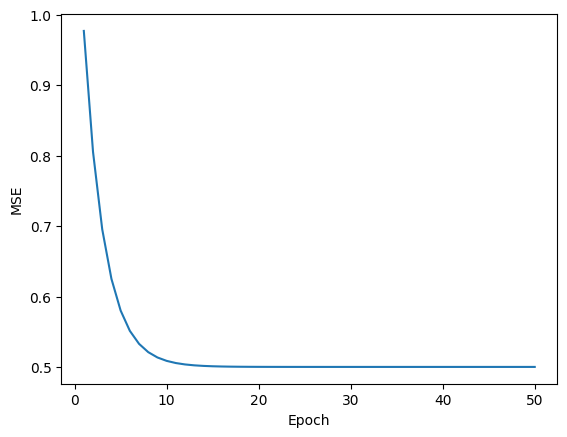

In [20]:
plt.plot(range(1, lr_model.n_iter+1), lr_model.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

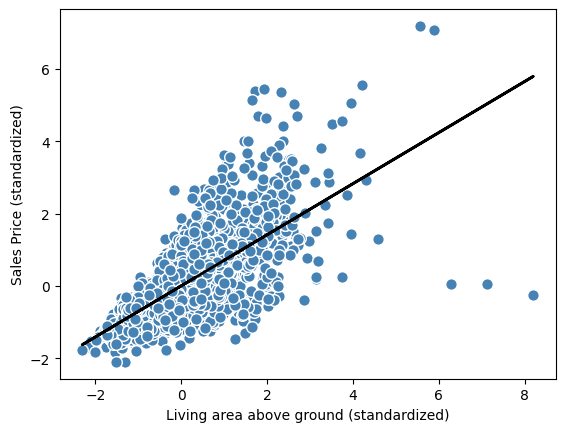

In [21]:
lin_regplot(X_std, y_std, lr_model)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sales Price (standardized)')
plt.show()

In [22]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr_model.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1,1))

In [23]:
print(f'Sales Price: ${target_reverted.flatten()[0]:.2f}')

Sales Price: $292507.07


In [24]:
print(f'Slope: {lr_model.w_[0]:.3f}')
print(f'Intercept: {lr_model.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


## Estimating the coefficient of a regression model via scikit-learn

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
slr_model = LinearRegression()
slr_model.fit(X, y)
y_pred = slr_model.predict(X)

In [33]:
print(f'Slope: {slr_model.coef_[0][0]:.3f}')
print(f'Slope: {slr_model.intercept_[0]:.3f}')

Slope: 111.666
Slope: 13342.979


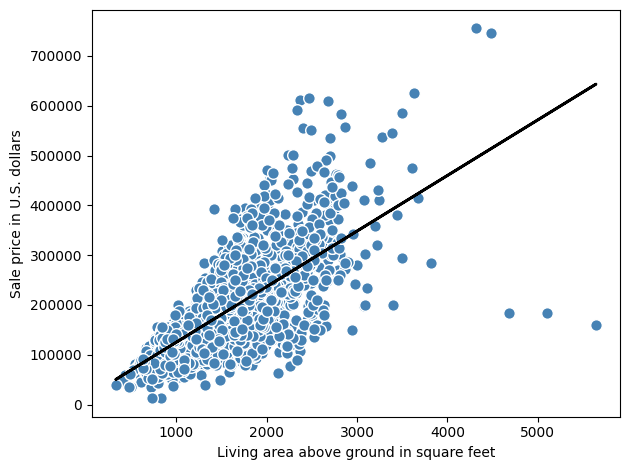

In [35]:
lin_regplot(X, y, slr_model)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.tight_layout()
plt.show()

## Fitting a robust regression model using RANSAC

In [36]:
from sklearn.linear_model import RANSACRegressor

In [37]:
ransac_model = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=0.95,
    residual_threshold=None,
    random_state=123
)

In [38]:
ransac_model.fit(X, y)

,estimator,LinearRegression()
,min_samples,0.95
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,100
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


In [43]:
inlier_mask = ransac_model.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac_model.predict(line_X[:, np.newaxis])

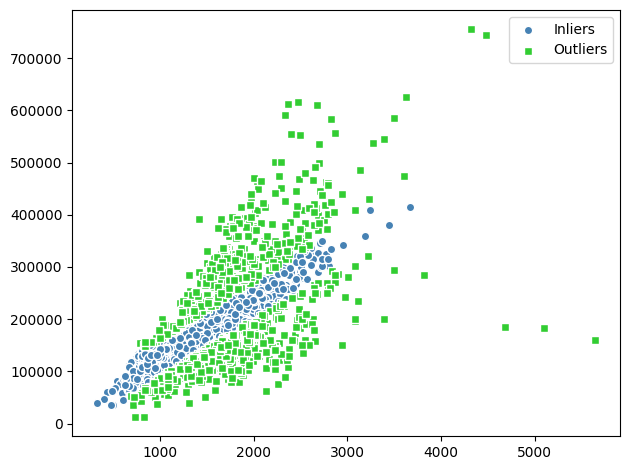

In [49]:
plt.scatter(
    X[inlier_mask],
    y[inlier_mask],
    c='steelblue',
    edgecolor='white',
    marker='o',
    label='Inliers'
)

plt.scatter(
    X[outlier_mask],
    y[outlier_mask],
    c='limegreen',
    edgecolor='white',
    marker='s',
    label='Outliers'
)

plt.legend()
plt.tight_layout()
plt.show()

## Evaluating the performance of linear regression models

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=123
)

In [54]:
slr_model = LinearRegression()
slr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [55]:
y_train_pred = slr_model.predict(X_train)
y_test_pred = slr_model.predict(X_test)

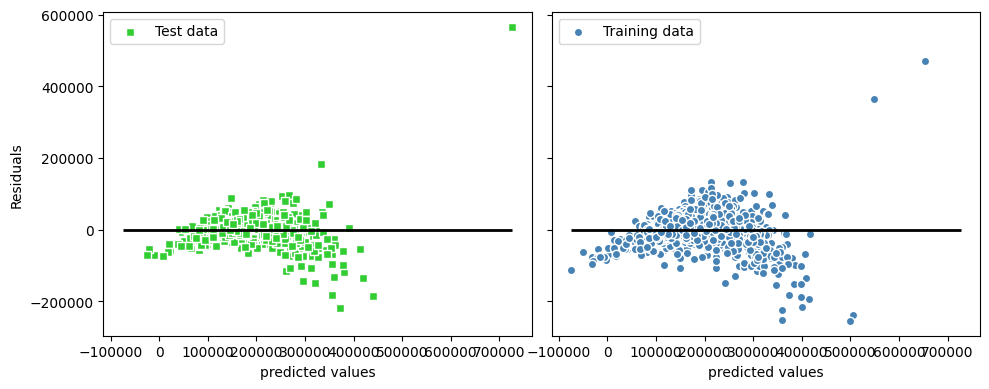

In [57]:
# Residual Plot

x_max = np.max(
    [np.max(y_train_pred), np.max(y_test_pred)]
)

x_min = np.min(
    [np.min(y_train_pred), np.min(y_test_pred)]
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10,4), sharey=True
)

ax1.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='limegreen',
    marker='s',
    edgecolor='white',
    label='Test data'
)

ax2.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='steelblue',
    marker='o',
    edgecolor='white',
    label='Training data'
)

ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()

In [65]:
# Compute the MSE
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [59]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

In [63]:
print(f'MSE train: {mse_train:.2f}\n\
MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [66]:
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

In [67]:
print(f'RMSE train: {rmse_train:.2f}\n\
RMSE test: {rmse_test:.2f}')

RMSE train: 38693.88
RMSE test: 38943.11


In [68]:
# Compute the R2 score
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'train R^2: {train_r2:.2f}\n\
test R^2: {test_r2:.2f}')

train R^2: 0.77
test R^2: 0.75


## Using regularized methods for regression

In [1]:
# Ridge Regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

# LASSO Regression
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

# ElasticNet Regression
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)